# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание данных

* **id** — уникальный идентификатор скважины;
* **f0**, **f1**, **f2** — три признака точек;
* **product** — объём запасов в скважине (тыс. баррелей).

## Условия задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Выбор-локации-для-скважины" data-toc-modified-id="Выбор-локации-для-скважины-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Выбор локации для скважины</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Условия-задачи" data-toc-modified-id="Условия-задачи-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Условия задачи</a></span></li></ul></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Объявим и проинициализируем необходимые константы.

In [2]:
# Бюджет на разработку скважин в регионе, млрд руб.
BUDGET = 10**10

# Доход с каждой единицы продукта, тыс. руб.
REVENUE_PER_PRODUCT = 450 * 10**3

# Количество разведочных скважин
N_EXPLORATORY_WELLS = 500

# Количество эксплуатационных скважин, заложенных в бюджет
N_PRODUCTION_WELLS = 200

STATE = np.random.RandomState(17)

Загрузим данные и отобразим первые пять строк, чтобы удостовериться в корректности процедуры. При чтении csv-файла будем использовать автоматическое определение разделителя с помощью движка python.

In [3]:
geo_df_0 = pd.read_csv('geo_data_0.csv', sep=None, engine='python')
geo_df_1 = pd.read_csv('geo_data_1.csv', sep=None, engine='python')
geo_df_2 = pd.read_csv('geo_data_2.csv', sep=None, engine='python')

display(geo_df_0.head())
display(geo_df_1.head())
display(geo_df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные загружены корректно.

Посмотрим на общую информацию о данных, в т.ч. на количество пропусков.

In [4]:
df_list = [geo_df_0, geo_df_1, geo_df_2]

for i, df in enumerate(df_list):
    print('Данные геологоразведки региона', i)
    print(df.info(memory_usage='deep'))
    print()

Данные геологоразведки региона 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB
None

Данные геологоразведки региона 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB
None

Данные геологоразведки региона 2
<class 'pandas.core.fra

Таблицы одинакового размера (5 столбцов, 100000 строк), пропущенных значений нет.

Теперь взглянем на базовые статистики данных.

In [5]:
for i, df in enumerate(df_list):
    print('Статистическое описание данных геологоразведки региона', i)
    display(df.describe())
    print()

Статистическое описание данных геологоразведки региона 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Статистическое описание данных геологоразведки региона 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Статистическое описание данных геологоразведки региона 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Видно, что в строках *min* и *max* нет заметно больших по модулю значений, т.е. в данных нет выбросов, которые существенно скажутся на обучении модели.

Кратко изучим матрицы рассеяния признаков.

<Figure size 432x288 with 0 Axes>

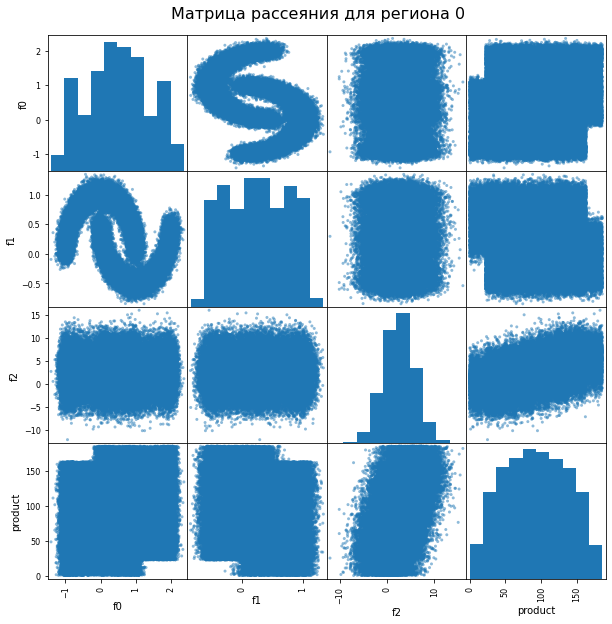

<Figure size 432x288 with 0 Axes>

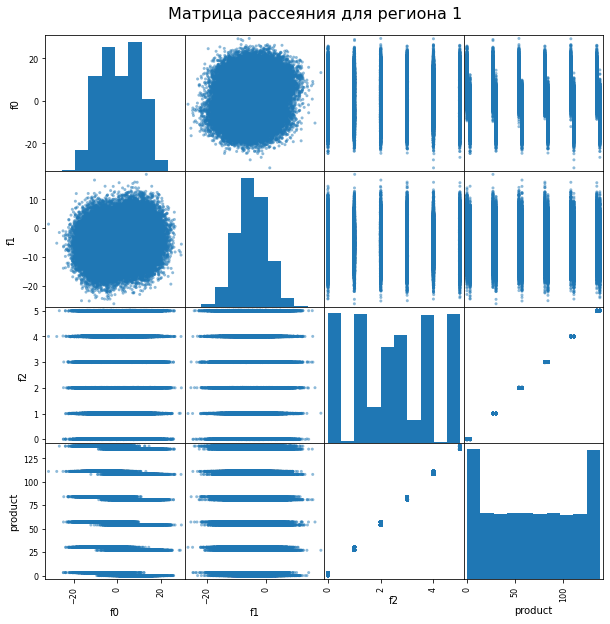

<Figure size 432x288 with 0 Axes>

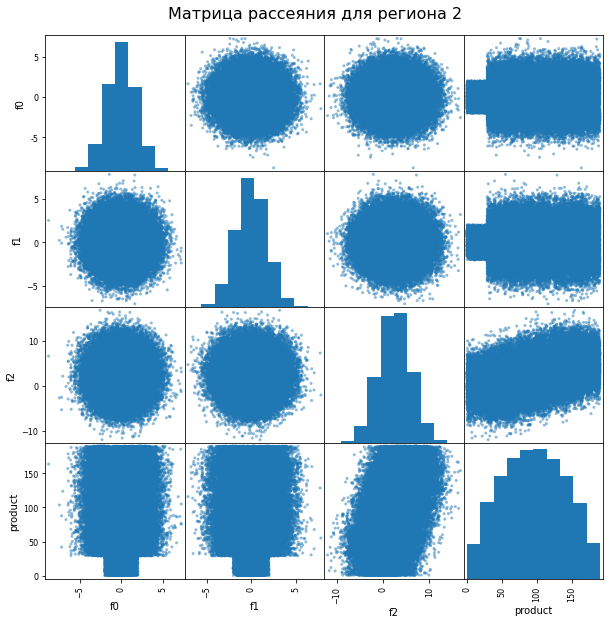

In [6]:
for i, df in enumerate(df_list):
    plt.figure()
    pd.plotting.scatter_matrix(df, figsize=(10, 10))
    plt.suptitle('Матрица рассеяния для региона ' + str(i), fontsize=16, y=0.92)
    plt.show()

Видны и линейные и нелинейные зависимости между признаками, также заметно, что часть признаков распределена почти нормально, в то время как другая часть - ненормально.

Проверим данные на дубликаты.

In [7]:
for i, df in enumerate(df_list):
    print('В данных геологоразведки', i, 'региона', df.duplicated().sum(), 'дубликатов')

В данных геологоразведки 0 региона 0 дубликатов
В данных геологоразведки 1 региона 0 дубликатов
В данных геологоразведки 2 региона 0 дубликатов


Дубликатов нет.

Проверим данные на наличие или отсутствие линейной зависимости с помощью коэффициента корреляции Пирсона.

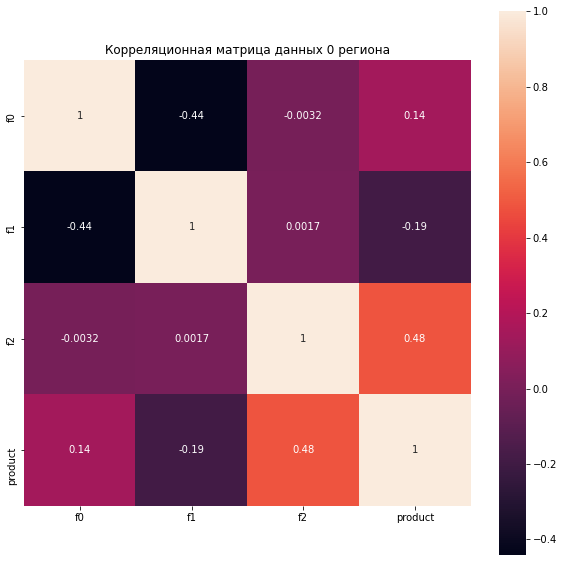

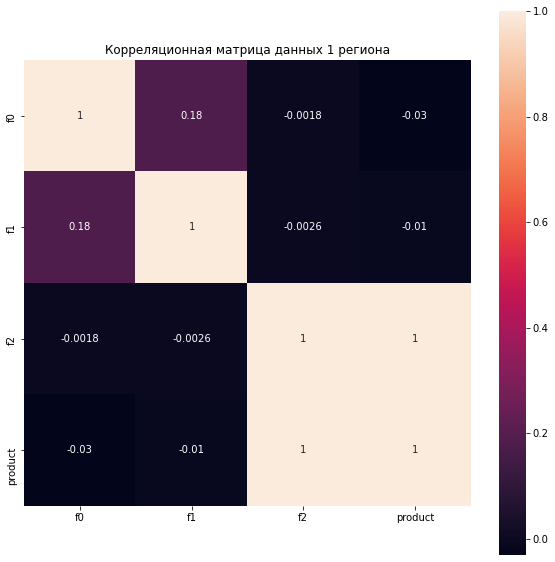

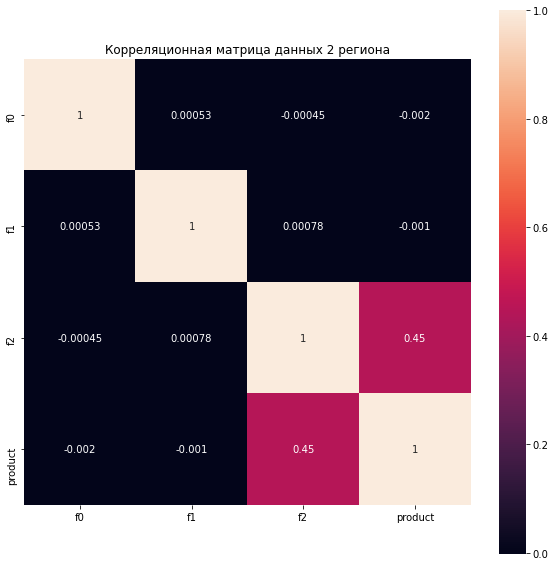

In [8]:
for i, df in enumerate(df_list):
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, robust=True, square=True, annot=True)
    plt.title('Корреляционная матрица данных ' + str(i) + ' региона')
    plt.show()

Во втором регионе видна линейная зависимость между признаком *f2* и *product*, что должно сказаться на качестве модели в лучшую сторону.

## Вывод

* Исходные данные представляют собой 3 таблицы с 5 столбцами и 100000 строками.
* Пропущенных данных нет.
* Дубликатов нет.
* Часть признаков распределена почти нормально, в то время как другая часть - ненормально.
* Сильной корреляции между признаками *f0*, *f1*, *f2* не обнаружено.
* В данных региона 1 есть линейная зависимость между признаками *f2* и *product*.

# Обучение и проверка модели

Разобъём данные регионов на обучающие и тестовые выборки в соотношении 3:1.

In [9]:
feature_cols = ['f0', 'f1', 'f2']

features = [df[feature_cols] for df in df_list]
target = [df['product'] for df in df_list]

features_train, features_valid, target_train, target_valid = zip(
    *[
        train_test_split(x, y, test_size=0.25, random_state=STATE)
        for x, y in zip(features, target)
    ]
)

Проверим для региона 0 корректность разбиения.

In [10]:
print('Размер тренировочных выборок:', features_train[0].shape, target_train[0].shape)
print('Размер тестовых выборок:', features_valid[0].shape, target_valid[0].shape)

Размер тренировочных выборок: (75000, 3) (75000,)
Размер тестовых выборок: (25000, 3) (25000,)


Обучим модель линейной регрессии, посчитаем прогнозы для каждого региона и запишем их в список.

In [11]:
models_list = [
    LinearRegression(normalize=True, n_jobs=-1).fit(x, y)
    for x, y in zip(features_train, target_train)
]

predictions_list = [
    pd.Series(model.predict(x), index=y.index)
    for x, y, model in zip(features_valid, target_valid, models_list)
]

Проверим для региона 0 корректность процедуры обучения-прогноза.

In [12]:
pd.concat([target_valid[0], predictions_list[0]], axis=1)

,product,0
53844,149.539046,82.021608
10034,58.459358,106.204317
2592,116.315406,94.949439
19398,122.935322,103.539245
26446,97.062256,130.163011
...,...,...
73423,50.189490,110.599522
14249,116.636528,81.557574
46345,122.133952,134.192502
51716,94.942189,73.584026


Выведем средние запасы по регионам (фактические и прогнозные) и среднеквадратичную ошибку.

In [13]:
mean_reserves_list = [y.mean() for y in target_valid]
mean_predicted_reserves_list = [p.mean() for p in predictions_list]
mse_list = [
    mean_squared_error(y_true, y_pred)
    for y_true, y_pred in zip(target_valid, predictions_list)
]

print('| {:^9} | {:^31} | {:^31} | {:^8} |'.format('№ региона', 'Фактический средний запас сырья',
                                                   'Средний запас сырья по прогнозу', 'RMSE'))
print('-' * 91)

for i, mr, mpr, mse in zip([*range(3)], mean_reserves_list, mean_predicted_reserves_list, mse_list):
    print('| {:^9} | {:^31.3f} | {:^31.3f} | {:^8.3f} |'.format(i, mr, mpr, mse**0.5))

| № региона | Фактический средний запас сырья | Средний запас сырья по прогнозу |   RMSE   |
-------------------------------------------------------------------------------------------
|     0     |             92.832              |             92.391              |  37.786  |
|     1     |             68.583              |             68.587              |  0.893   |
|     2     |             95.164              |             94.710              |  40.121  |


Фактические средние и прогнозные значения запасов очень близки. Заметна существенная разница между 1 регионом и остальными по средним запасам и полученной ошибке прогноза: для 0-го и 2-го регионов *RMSE* получился порядка стандартного отклонения, а для 1-го - на два порядка меньше (меньше 1000 баррелей), что говорит о лучшем качестве модели для 1-го региона.

## Вывод

* Данные для 3-х регионов были разбиты на обучающие и тестовые выборки в соотношении 3:1.
* Проведено обучение модели линейной регрессии и получены прогнозные значения запасов сырья.
* Фактические и прогнозные средние значения запасов практически совпали.
* Качество моделей на данных 0-го и 2-го регионов удовлетворительное, а 1-го региона - лучше на два порядка по метрике *RMSE*.

# Подготовка к расчёту прибыли

Посчитаем запасы, достаточные для безубыточной добычи, используя имеющиеся значения бюджета и дохода от 1000 баррелей запасов.

In [14]:
sufficient_reserves = BUDGET / REVENUE_PER_PRODUCT
print('Достаточные запасы сырья для безубыточной добычи, тыс. баррелей: {:.6}'.format(sufficient_reserves))

Достаточные запасы сырья для безубыточной добычи, тыс. баррелей: 22222.2


Сравним средние запасы и достаточные для безубыточной добычи. Посчитаем, сколько средне статистических скважин нужно для каждого из трёх регионов.

In [15]:
print('Количество скважин для безубыточной добычи')

for i, mr in enumerate(mean_reserves_list):
    well_num = int(np.ceil(sufficient_reserves / mr))
    print('Регион {}: {}'.format(i, well_num))

Количество скважин для безубыточной добычи
Регион 0: 240
Регион 1: 325
Регион 2: 234


В каждом регионе нужно больше таких абстрактных скважин со средними запасами, чем запланировано разрабатывать (200 скважин).

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели и функцию для применения техники *bootstrap*.

In [16]:
def count_profit(target, predictions, count):
    """
    Функция считает прибыль по выбранным скважинам с максимальными запасами и предсказаниям модели
    
    """
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return REVENUE_PER_PRODUCT * selected.sum() - BUDGET


def bootstrap(target, predictions, n_iter=1000, n_sample=N_EXPLORATORY_WELLS):
    """
    Функция создаёт n_iter выборок размером (n_sample,) из целевой выборки и
    выборки с прогнозами (с теми же индексами), считает для каждых прибыль и
    возвращает список прибылей.
    
    """
    values = []

    for i in range(n_iter):
        
        target_subsample = target.sample(n=n_sample, replace=True, random_state=STATE)
        predictions_subsample = predictions[target_subsample.index]
        
        profit = count_profit(target_subsample, predictions_subsample, N_PRODUCTION_WELLS)
        values.append(profit)

    values = pd.Series(values)
    return values

## Вывод

* Достаточные запасы сырья для безубыточной добычи: 22222.2 тыс. баррелей.
* Средних запасов в каждом регионе меньше достаточных в >200 раз.
* Написаны функции для расчёта прибыли и применения техники *bootstrap*.

# Расчёт прибыли и рисков 

Рассчитаем 1000 значений прибыли на бутстрэп-выборках для каждого региона.

In [17]:
revenue_list = [
    bootstrap(y_true, y_pred)
    for y_true, y_pred in zip(target_valid, predictions_list)
]

Выведем средние значения прибыли, нижние и верхние границы доверительных интервалов и риски убытков для трёх регионов.

In [18]:
mean_revenue_list, lower_revenue_list, higher_revenue_list, risk_list = zip(
    *[
        [
            r.mean(),                                    # средняя прибыль
            r.quantile(0.025),                           # 2,5% квантиль прибыли
            r.quantile(0.975),                           # 97,5% квантиль прибыли
            stats.percentileofscore(r, 0, kind='strict') # риск убытков
        ]
        for r in revenue_list
    ]
)

print('| {:^9} | {:^26} | {:^23} | {:^15} |'.format('№ региона', 'Средняя прибыль, млн. руб.',
                                                   'Доверительный интервал', 'Риск убытков, %'))
print('-' * 86)

for i, mrev, lrev, hrev, risk in zip(
    [*range(3)],
    mean_revenue_list,
    lower_revenue_list,
    higher_revenue_list,
    risk_list
):
    print('| {:^9} | {:^26.6} | ({:^9.6} - {:^9.6}) | {:^15.3} |'\
          .format(i, mrev / 10**6, lrev / 10**6, hrev / 10**6, risk))

| № региона | Средняя прибыль, млн. руб. | Доверительный интервал  | Риск убытков, % |
--------------------------------------------------------------------------------------
|     0     |          477.542           | (-37.0293  -  1000.27 ) |       4.1       |
|     1     |          482.698           | ( 87.3201  -  903.962 ) |       0.6       |
|     2     |          409.853           | (-140.749  -  972.084 ) |       7.1       |


Видим, что только в 1-м регионе вероятность убытков меньше 2.5%, что даёт возможность рекомендовать его для разработки. С вероятностью 97.5% можно гарантировать, что доход от разработки скважин в данном регионе будет не меньше 86.645 млн. руб при среднем доходе 478.019 млн. руб.

## Вывод

Анализ результатов показал, что в 1-м регионе вероятность убытков меньше 2.5%, а значит, его можно рекомендовать для разработки. Средний доход составит **478.019** млн. руб., а минимальный гарантированный - **86.645** млн. руб.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован